# Lab 4: Neurons from scratch

The code below defines some simple feed forward networks. Try them out, with the different data sets, and see what happens inside the models.

We start, as usual, by loading some useful modules.

In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_moons, make_blobs  # Toy data

import matplotlib.pyplot as plt

# Data

## Plotting helper function

In [2]:
def plot_classification(X, y, classifier=None):
  """Plotting function"""
  plt.figure(figsize=(4, 4), dpi=100)
  markers = ['o', 's', 'd']
  for j, label in enumerate(np.unique(y)):
    if X.shape[1] == 2:
      # No pseudo input
      plt.scatter(X[y==label, 0], X[y==label, 1], c=y[y==label], s=40, marker=markers[j], edgecolor='k', cmap='coolwarm', vmin=y.min(), vmax=y.max())
    else:
      # X includes pseudo inputs
      plt.scatter(X[y==label, 1], X[y==label, 2], c=y[y==label], s=40, marker=markers[j], edgecolor='k', cmap='coolwarm', vmin=y.min(), vmax=y.max())
  if classifier is not None:
    # Create a plotting mesh
    a = plt.axis()          # The mesh will adapt plotted data
    XX, YY = np.meshgrid(np.linspace(a[0], a[1], 50),
                        np.linspace(a[2], a[3], 50))
    mesh_points = [np.vstack(XX.ravel()), np.vstack(YY.ravel())]  # Reshape the x and y coordinates to columns
    mesh_points.insert(0, np.ones(mesh_points[0].shape))  # Add pseudo input
    mesh_points = np.concatenate(mesh_points, axis=1)     # Convert to numpy array
    # Run classification
    Z = classifier.predict_proba(mesh_points)
    if len(Z.shape) > 1:
      Z = classifier.predict(mesh_points)
      plt.pcolor(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', zorder=-1)
    else:
      # Plot, contourf will interpolate the colour between our mesh points
      plt.contourf(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', zorder=-1)
    
  plt.tight_layout()
  plt.show()

## Loading the data

Let's make some data. Each of the three following cells will generate a data set. *These overwrite each other.*

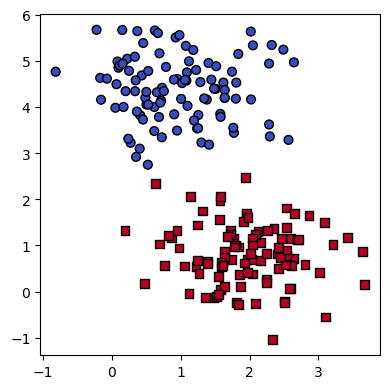

(array([[1.        , 2.59193175, 1.14706863],
        [1.        , 1.7756532 , 1.15670278],
        [1.        , 2.8032241 , 0.5802936 ],
        [1.        , 1.6090616 , 0.61957339],
        [1.        , 2.04921553, 5.33233847]]),
 array([1, 1, 1, 1, 0]))

In [3]:
X, y = make_blobs(n_samples=200, centers=2, cluster_std=.7, n_features=2, random_state=0)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # Add pseudo input

plot_classification(X, y)
X[:5], y[:5]

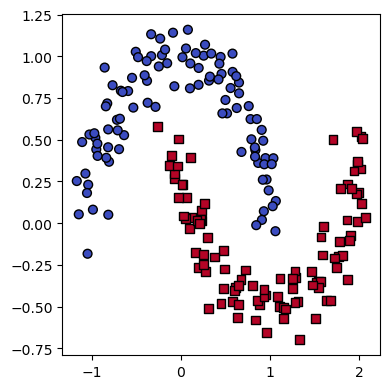

(array([[ 1.        ,  0.79235735,  0.50264857],
        [ 1.        ,  1.63158315, -0.4638967 ],
        [ 1.        , -0.06710927,  0.26776706],
        [ 1.        , -1.04412427, -0.18260761],
        [ 1.        ,  1.76704822, -0.19860987]]),
 array([0, 1, 1, 0, 1]))

In [4]:
X, y = make_moons(n_samples=200, noise=.1, random_state=0)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # Add pseudo input

plot_classification(X, y)
X[:5], y[:5]

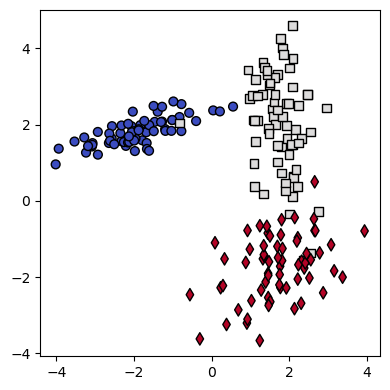

(array([[ 1.        ,  2.00120424,  3.48585849],
        [ 1.        , -1.27565612,  2.07888341],
        [ 1.        ,  2.65445232, -0.77822912],
        [ 1.        ,  0.92692666, -0.77581931],
        [ 1.        , -1.78887301,  1.58891079]]),
 array([1, 0, 2, 2, 0]))

In [5]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=3, class_sep=1.8,
                           n_clusters_per_class=1, random_state=0)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # Add pseudo input

plot_classification(X, y)
X[:5], y[:5]


# Modelling

Below is a standard perceptron. The perceptron is a superset of linear classifiers where our logistic regression model is a member.

In [6]:
from sklearn.metrics import accuracy_score

class Perceptron:
  def __init__(self, n_dim):
    self.theta_ = np.random.normal(size=n_dim)

  def _sigmoid(self, z):
    return 1/(1+np.exp(-z))

  def predict(self, X):
    return np.round(self.predict_proba(X))
  
  def predict_proba(self, X):
    return self._sigmoid(X.dot(np.vstack(self.theta_))).ravel()

  def score(self, X, y):
    return accuracy_score(y, self.predict(X))

model = Perceptron(n_dim=X.shape[1])

The above defined model is not trained yet. It represents a random partitioning of the feature space. As the model is small, we can let scipy do the optimization. Scipy's minimize will approximate the shape of our parameter space and find some local or global minimum. Can you see which loss function is being used?

In [7]:
from scipy.optimize import minimize

def loss(X, y, theta):
  model.theta_ = theta
  from_data = np.mean((model.predict_proba(X)-y)**2)
  from_regularization = .01*np.mean(theta**2)
  return from_data + from_regularization

ret = minimize(lambda theta: loss(X, y, theta), model.theta_)
model.theta_ = ret.x

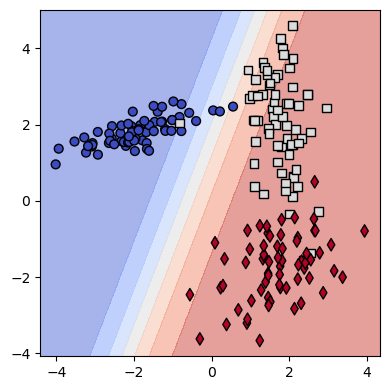

Model accuracy: 66.0%


In [8]:
 plot_classification(X, y, model)
 print("Model accuracy: %.1f%%" % (100*model.score(X, y)))

In [9]:
class MultiLayerPerceptron:
  def __init__(self, n_dim, n_hidden, n_output):
    """MLP"""
    self._W1 = np.random.normal(size=(n_dim, n_hidden))
    self._W2 = np.random.normal(size=(n_hidden, n_output))

  @property
  def theta_(self):
    return np.concatenate((self._W1.ravel(), self._W2.ravel()))

  @theta_.setter
  def theta_(self, theta):
    self._W1 = theta[:np.prod(self._W1.shape)].reshape(self._W1.shape)
    self._W2 = theta[np.prod(self._W1.shape):].reshape(self._W2.shape)

  def _sigmoid(self, z):
    return 1/(1+np.exp(-z))

  def predict(self, X):
    return np.argmax(self.predict_proba(X), axis=1)
  
  def predict_proba(self, X):
    hidden_scores = self._sigmoid(X.dot(self._W1))
    scores = self._sigmoid(hidden_scores.dot(self._W2))
    return scores

  def score(self, X, y):
    return accuracy_score(y, self.predict(X))

model = MultiLayerPerceptron(n_dim=X.shape[1],
                             n_hidden=8,
                             n_output=len(np.unique(y)))

As the output from this model is a pdf over categories, we must map our labels, encoded as numbers, to a one-hot representation.

In [10]:
def onehot(labels):
  ret = np.zeros((len(labels), len(np.unique(labels))))
  for i, l in enumerate(labels):
    ret[i, l] = 1
  return ret

ret = minimize(lambda theta: loss(X, onehot(y), theta), model.theta_)
model.theta_ = ret.x

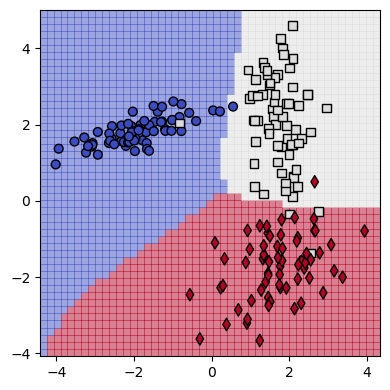

Model accuracy: 96.5%


In [11]:
 plot_classification(X, y, model)
 print("Model accuracy: %.1f%%" % (100*model.score(X, y)))